In this notebook we want to try an experiment with time prediction of the Sun. A way to pass data by sequence is defined and some changes in the architecture but still some issues.

In [1]:
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from matplotlib.pyplot import imshow
import operator
from functools import reduce

import torch
from torch import nn, optim
from sdo.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

%matplotlib inline

In [2]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [34]:
# let's start simple by considering one single channel
# single channel has a bug in the data loader (one xextra dim is added)
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA', 'AIA', 'AIA']
channels = ['0171', '0193', '0304']

In [35]:
#some cuda initialization
torch.backends.cudnn.enabled = True
cuda_device = 5
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available! Unable to continue")
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
device, torch.cuda.current_device(), torch.cuda.device_count()))

Using device cuda:5 for training, current device: 0, total devices: 6


In [38]:
%%time
# one image every 12 hours for 4 years, prediction 12h in advance
train_data = SDO_Dataset(device=device, instr=instr, channels=channels, yr_range=[2015,2018], 
                         mnt_step=1, day_step=1, h_step=12, min_step=61, subsample=subsample, 
                         test_ratio=0.3, normalization=0, scaling=True)

[2019-07-24 21:19:56] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-24 21:19:56] INFO:sdo.sdo_dataset:Training on months "[1 2 3 4 5 6 7]"
[2019-07-24 21:19:56] DEBUG:sdo.sdo_dataset:Timestamps requested values: 
[2019-07-24 21:19:56] DEBUG:sdo.sdo_dataset:Years: 2015,2016,2017,2018
[2019-07-24 21:19:56] DEBUG:sdo.sdo_dataset:Months: 1,2,3,4,5,6,7
[2019-07-24 21:19:57] DEBUG:sdo.sdo_dataset:Days: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
[2019-07-24 21:19:57] DEBUG:sdo.sdo_dataset:Hours: 0,12
[2019-07-24 21:19:57] DEBUG:sdo.sdo_dataset:Minutes: 0
[2019-07-24 21:19:57] INFO:sdo.sdo_dataset:Max number of timestamps: 1736
[2019-07-24 21:19:59] INFO:sdo.sdo_dataset:Timestamps found in the inventory: 1679 (0.97)
[2019-07-24 21:20:00] INFO:sdo.sdo_dataset:N timestamps discarded because channel is missing = 0 (0.00000)
[2019-07-24 21:20:00] INFO:sdo.sdo_dataset:Selected timestamps = 1679
[2019-07-24 21:20:0

In [39]:
"""
In this module we want to define an encoder/decoder RNN architecture
"""
def prod(iterable):
    return reduce(operator.mul, iterable, 1)


class EncoderDecoderRNN(nn.Module):
    """
    This is a RNN that output the next image of a sequence of images.
    """
    def __init__(self, input_shape=[1, 512, 512], lstm_input_dim=1024):
        super(EncoderDecoderRNN, self).__init__()
        self.lstm_input_dim = lstm_input_dim
        self.num_channels = input_shape[0]
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(in_channels=self.num_channels, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        
        self.dconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3)
        self.dconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3)
        self.dconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3)
        self.dconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3)
        self.dconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=self.num_channels, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)
      
        sample_encoder_input = torch.zeros(input_shape)
        sample_encoder_output = self._encoder(sample_encoder_input.unsqueeze(0))[0]
        sample_encoder_output_dim = sample_encoder_output.nelement()

        # TODO: Try more layers.
        self.lin1 = nn.Linear(sample_encoder_output_dim,  self.lstm_input_dim)
        self.lstm = nn.LSTM(input_size=self.lstm_input_dim, hidden_size=self.lstm_input_dim, 
                            num_layers=1, batch_first=True)
        self.lstm_fc = nn.Linear(in_features=self.lstm_input_dim, out_features=sample_encoder_output_dim)

        print('Autoencoder architecture:')
        print('Input shape: {}'.format(input_shape))
        print('Input dim  : {}'.format(prod(input_shape)))
        print('Encoded dim: {}'.format(sample_encoder_output_dim))
        print('Learnable params: {}'.format(sum([p.numel() for p in self.parameters()])))

    def _encoder(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x, indices1 = self.pool(x)
        x = self.conv3(x)
        x, indices2 = self.pool(x)
        x = self.conv4(x)
        x, indices3 = self.pool(x)
        x = self.conv5(x)
        x, indices4 = self.pool(x)
        x = F.relu(x)
        return x, indices1, indices2, indices3, indices4

    def _decoder(self, x, indices1, indices2, indices3, indices4):
        x = self.unpool(x, indices4)
        x = self.dconv5(x)
        x = F.relu(x)
        x = self.unpool(x, indices3)
        x = self.dconv4(x)
        x = F.relu(x)
        x = self.unpool(x, indices2)
        x = self.dconv3(x)
        x = F.relu(x)
        x = self.unpool(x, indices1)
        x = self.dconv2(x)
        x = F.relu(x)
        x = self.dconv1(x)
        x = torch.relu(x)
        return x

    def forward(self, x):
        # x has shape B x T x C x H x W
        batch_size = x.shape[0]
        sequence_size = x.shape[1]
        n_channels = x.shape[2]
        img_size = x.shape[3]
        encoded_x = []
        decoded_x = []
        indices_t = []
        for t in range(sequence_size):
            xt = x[:, t, :, :, :]
            #print("Input encoder", xt.shape)
            xt, indices1, indices2, indices3, indices4 = self._encoder(xt)
            #print("Encoded time stamp", xt.shape)
            Shap = xt.shape
            xt = xt.view(Shap[0], -1)
            #print("Encoded time stamp post reshaping", xt.shape)
            xt = self.lin1(xt)
            xt = F.relu(xt)
            #print("Encoded time stamp post FC", xt.shape)
            encoded_x.append(xt)
            indices_t.append([indices1, indices2, indices3, indices4])
        x = torch.stack(encoded_x)
        #print("Stacked encoded input to LSTM", x.shape)
        x, _ = self.lstm(x)
        #print("Output LSTM", x.shape)
        x = self.lstm_fc(x)
        # print("Output LSTM, post FC", x.shape)
        for t in range(sequence_size):
            xt = x[t, :, :]
            xt = xt.reshape(Shap)
         # print("Reshaping, Input decoder", xt.shape)
            xt = self._decoder(xt, *indices_t[t])
            decoded_x.append(xt)
          #  print("Output single decoder", xt.shape)
        #x = x[0,:,]
        x = torch.stack(decoded_x)
        x = x.view(batch_size, sequence_size, n_channels, img_size, img_size)
        # print("Output, stacked decoder", x.shape)
        return x

In [ ]:
def print_images(orig_data, output, channels):
    for channel in len(channels):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(orig_data, norm=None, cmap='hot')
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.imshow(channel_dimmed, norm=None, cmap='hot')
        print('\nChannel: {} (left: original, right: predicted)'.format(channel)
        plt.plot(output_numpy, label='Dimming factors (predicted)')
        title = 'training dimming factors' if train else 'testing dimming factors'
        plt.title(title)
        plt.legend()
        plt.show()


In [43]:
#let's define a RNN model
model = EncoderDecoderRNN(input_shape=[len(channels), 512, 512])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

Autoencoder architecture:
Input shape: [3, 512, 512]
Input dim  : 786432
Encoded dim: 57600
Learnable params: 127049411


In [44]:
# is the shuffling in the data loader shuffling the order of the batches or inside the batch
# for now we are converting a batch (of size 6) into a sequence, where the first 5 are used for training and the last for test.
seq_len = 6
train_data_loader = DataLoader(train_data, batch_size=seq_len, shuffle=False)

Train Epoch: 0 [0/1679 (0%)]	Loss: 0.204710

Channel: 0171 (left: original, right: predicted)


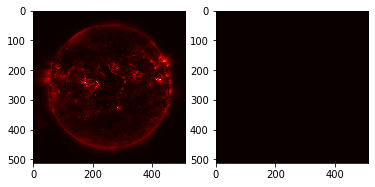


Channel: 0193 (left: original, right: predicted)


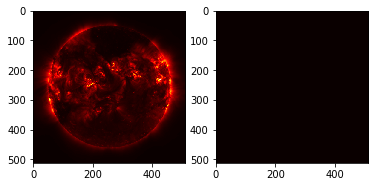


Channel: 0304 (left: original, right: predicted)


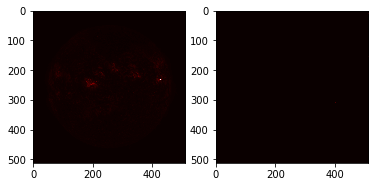

Train Epoch: 0 [10/1679 (4%)]	Loss: 0.219786
Train Epoch: 0 [20/1679 (7%)]	Loss: 0.159526
Train Epoch: 0 [30/1679 (11%)]	Loss: 0.099314
Train Epoch: 0 [40/1679 (14%)]	Loss: 0.154887
Train Epoch: 0 [50/1679 (18%)]	Loss: 0.147586
Train Epoch: 0 [60/1679 (21%)]	Loss: 0.093334
Train Epoch: 0 [70/1679 (25%)]	Loss: 0.055516
Train Epoch: 0 [80/1679 (29%)]	Loss: 0.080184
Train Epoch: 0 [90/1679 (32%)]	Loss: 0.044823
Train Epoch: 0 [100/1679 (36%)]	Loss: 0.026684

Channel: 0171 (left: original, right: predicted)


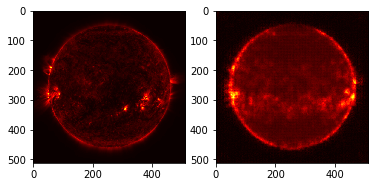


Channel: 0193 (left: original, right: predicted)


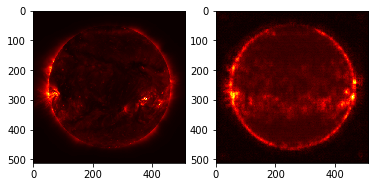


Channel: 0304 (left: original, right: predicted)


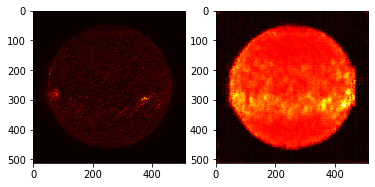

Train Epoch: 0 [110/1679 (39%)]	Loss: 0.044210
Train Epoch: 0 [120/1679 (43%)]	Loss: 0.025231
Train Epoch: 0 [130/1679 (46%)]	Loss: 0.038421
Train Epoch: 0 [140/1679 (50%)]	Loss: 0.018101
Train Epoch: 0 [150/1679 (54%)]	Loss: 0.022150
Train Epoch: 0 [160/1679 (57%)]	Loss: 0.017279
Train Epoch: 0 [170/1679 (61%)]	Loss: 0.038328
Train Epoch: 0 [180/1679 (64%)]	Loss: 0.019625
Train Epoch: 0 [190/1679 (68%)]	Loss: 0.035162
Train Epoch: 0 [200/1679 (71%)]	Loss: 0.018438

Channel: 0171 (left: original, right: predicted)


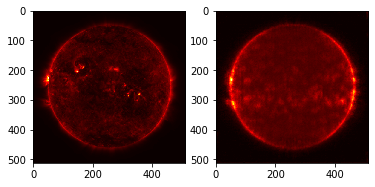


Channel: 0193 (left: original, right: predicted)


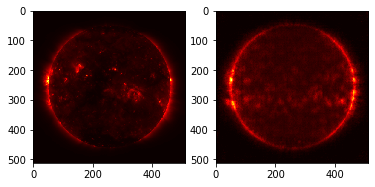


Channel: 0304 (left: original, right: predicted)


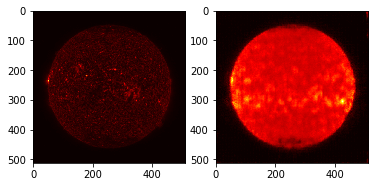

Train Epoch: 0 [210/1679 (75%)]	Loss: 0.019318
Train Epoch: 0 [220/1679 (79%)]	Loss: 0.018442
Train Epoch: 0 [230/1679 (82%)]	Loss: 0.016857
Train Epoch: 0 [240/1679 (86%)]	Loss: 0.016912
Train Epoch: 0 [250/1679 (89%)]	Loss: 0.021701
Train Epoch: 0 [260/1679 (93%)]	Loss: 0.036190
Train Epoch: 0 [270/1679 (96%)]	Loss: 0.021557
Train Epoch: 1 [0/1679 (0%)]	Loss: 0.096245

Channel: 0171 (left: original, right: predicted)


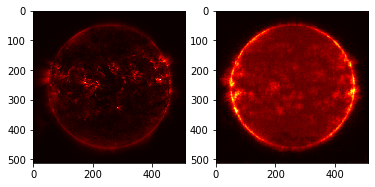


Channel: 0193 (left: original, right: predicted)


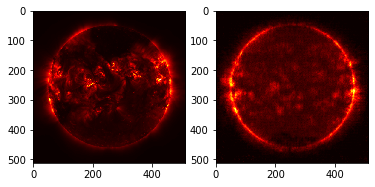


Channel: 0304 (left: original, right: predicted)


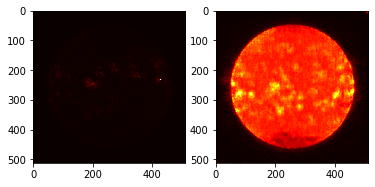

Train Epoch: 1 [10/1679 (4%)]	Loss: 0.076543
Train Epoch: 1 [20/1679 (7%)]	Loss: 0.066746
Train Epoch: 1 [30/1679 (11%)]	Loss: 0.065598
Train Epoch: 1 [40/1679 (14%)]	Loss: 0.095665
Train Epoch: 1 [50/1679 (18%)]	Loss: 0.103995
Train Epoch: 1 [60/1679 (21%)]	Loss: 0.079001
Train Epoch: 1 [70/1679 (25%)]	Loss: 0.043707
Train Epoch: 1 [80/1679 (29%)]	Loss: 0.061521
Train Epoch: 1 [90/1679 (32%)]	Loss: 0.037159
Train Epoch: 1 [100/1679 (36%)]	Loss: 0.020537

Channel: 0171 (left: original, right: predicted)


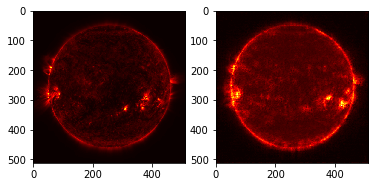


Channel: 0193 (left: original, right: predicted)


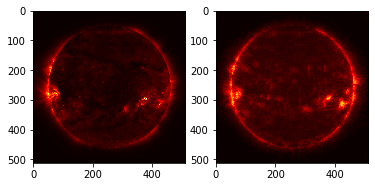


Channel: 0304 (left: original, right: predicted)


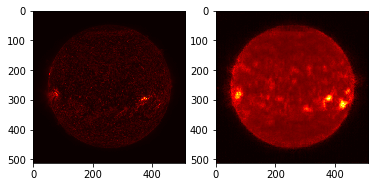

Train Epoch: 1 [110/1679 (39%)]	Loss: 0.033188
Train Epoch: 1 [120/1679 (43%)]	Loss: 0.022243
Train Epoch: 1 [130/1679 (46%)]	Loss: 0.031229
Train Epoch: 1 [140/1679 (50%)]	Loss: 0.015430
Train Epoch: 1 [150/1679 (54%)]	Loss: 0.019291
Train Epoch: 1 [160/1679 (57%)]	Loss: 0.014366
Train Epoch: 1 [170/1679 (61%)]	Loss: 0.025720
Train Epoch: 1 [180/1679 (64%)]	Loss: 0.015674
Train Epoch: 1 [190/1679 (68%)]	Loss: 0.025800
Train Epoch: 1 [200/1679 (71%)]	Loss: 0.016459

Channel: 0171 (left: original, right: predicted)


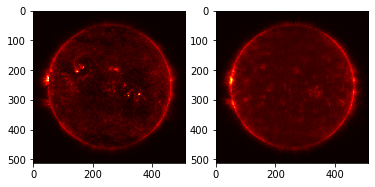


Channel: 0193 (left: original, right: predicted)


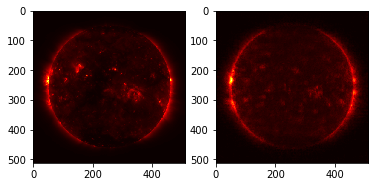


Channel: 0304 (left: original, right: predicted)


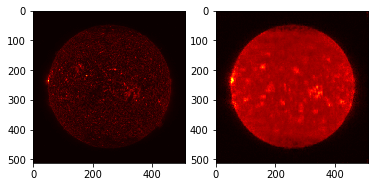

Train Epoch: 1 [210/1679 (75%)]	Loss: 0.018332
Train Epoch: 1 [220/1679 (79%)]	Loss: 0.017007
Train Epoch: 1 [230/1679 (82%)]	Loss: 0.015764
Train Epoch: 1 [240/1679 (86%)]	Loss: 0.016394
Train Epoch: 1 [250/1679 (89%)]	Loss: 0.019967
Train Epoch: 1 [260/1679 (93%)]	Loss: 0.029638
Train Epoch: 1 [270/1679 (96%)]	Loss: 0.020202
Train Epoch: 2 [0/1679 (0%)]	Loss: 0.081525

Channel: 0171 (left: original, right: predicted)


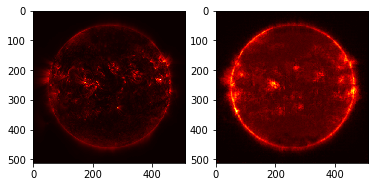


Channel: 0193 (left: original, right: predicted)


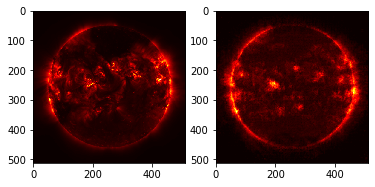


Channel: 0304 (left: original, right: predicted)


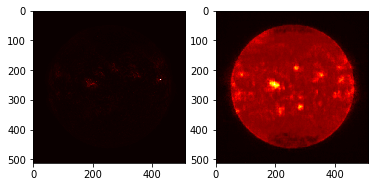

Train Epoch: 2 [10/1679 (4%)]	Loss: 0.069167
Train Epoch: 2 [20/1679 (7%)]	Loss: 0.058476
Train Epoch: 2 [30/1679 (11%)]	Loss: 0.048363
Train Epoch: 2 [40/1679 (14%)]	Loss: 0.074955
Train Epoch: 2 [50/1679 (18%)]	Loss: 0.081153
Train Epoch: 2 [60/1679 (21%)]	Loss: 0.073134
Train Epoch: 2 [70/1679 (25%)]	Loss: 0.041188
Train Epoch: 2 [80/1679 (29%)]	Loss: 0.055174
Train Epoch: 2 [90/1679 (32%)]	Loss: 0.032585
Train Epoch: 2 [100/1679 (36%)]	Loss: 0.018881

Channel: 0171 (left: original, right: predicted)


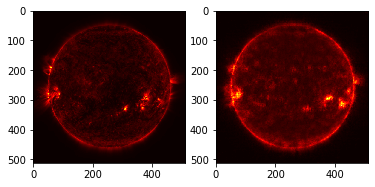


Channel: 0193 (left: original, right: predicted)


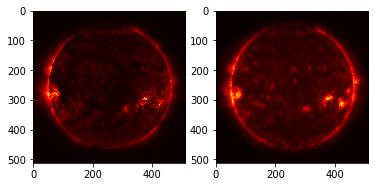


Channel: 0304 (left: original, right: predicted)


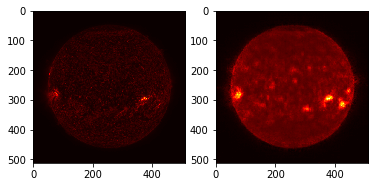

Train Epoch: 2 [110/1679 (39%)]	Loss: 0.029282
Train Epoch: 2 [120/1679 (43%)]	Loss: 0.020075
Train Epoch: 2 [130/1679 (46%)]	Loss: 0.027586
Train Epoch: 2 [140/1679 (50%)]	Loss: 0.015000
Train Epoch: 2 [150/1679 (54%)]	Loss: 0.016843
Train Epoch: 2 [160/1679 (57%)]	Loss: 0.014171
Train Epoch: 2 [170/1679 (61%)]	Loss: 0.022591
Train Epoch: 2 [180/1679 (64%)]	Loss: 0.014264
Train Epoch: 2 [190/1679 (68%)]	Loss: 0.022897
Train Epoch: 2 [200/1679 (71%)]	Loss: 0.015890

Channel: 0171 (left: original, right: predicted)


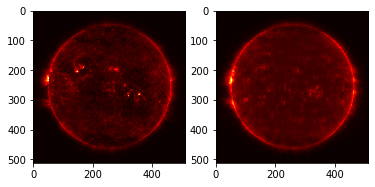


Channel: 0193 (left: original, right: predicted)


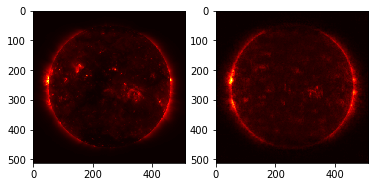


Channel: 0304 (left: original, right: predicted)


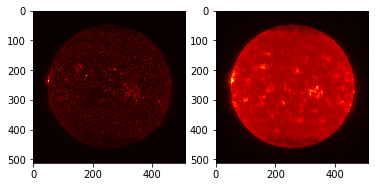

Train Epoch: 2 [210/1679 (75%)]	Loss: 0.018029
Train Epoch: 2 [220/1679 (79%)]	Loss: 0.016530
Train Epoch: 2 [230/1679 (82%)]	Loss: 0.015382
Train Epoch: 2 [240/1679 (86%)]	Loss: 0.016109
Train Epoch: 2 [250/1679 (89%)]	Loss: 0.018948
Train Epoch: 2 [260/1679 (93%)]	Loss: 0.026903
Train Epoch: 2 [270/1679 (96%)]	Loss: 0.019187
Train Epoch: 3 [0/1679 (0%)]	Loss: 0.074337

Channel: 0171 (left: original, right: predicted)


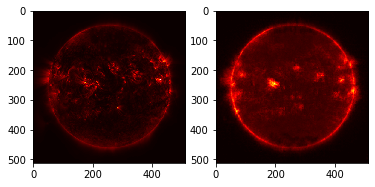


Channel: 0193 (left: original, right: predicted)


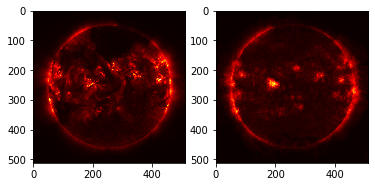


Channel: 0304 (left: original, right: predicted)


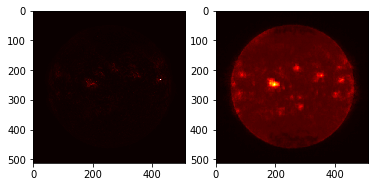

Train Epoch: 3 [10/1679 (4%)]	Loss: 0.061869
Train Epoch: 3 [20/1679 (7%)]	Loss: 0.055569
Train Epoch: 3 [30/1679 (11%)]	Loss: 0.041393
Train Epoch: 3 [40/1679 (14%)]	Loss: 0.070631
Train Epoch: 3 [50/1679 (18%)]	Loss: 0.071768
Train Epoch: 3 [60/1679 (21%)]	Loss: 0.061647
Train Epoch: 3 [70/1679 (25%)]	Loss: 0.035857
Train Epoch: 3 [80/1679 (29%)]	Loss: 0.049456
Train Epoch: 3 [90/1679 (32%)]	Loss: 0.030697
Train Epoch: 3 [100/1679 (36%)]	Loss: 0.018341

Channel: 0171 (left: original, right: predicted)


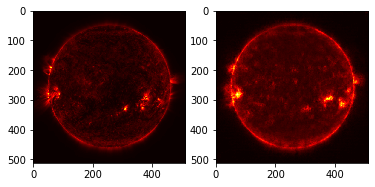


Channel: 0193 (left: original, right: predicted)


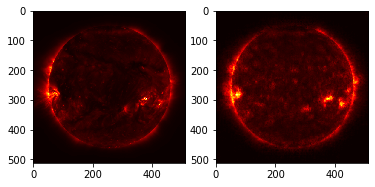


Channel: 0304 (left: original, right: predicted)


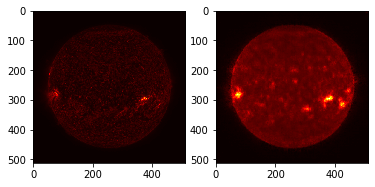

Train Epoch: 3 [110/1679 (39%)]	Loss: 0.027463
Train Epoch: 3 [120/1679 (43%)]	Loss: 0.019758
Train Epoch: 3 [130/1679 (46%)]	Loss: 0.026349
Train Epoch: 3 [140/1679 (50%)]	Loss: 0.015206
Train Epoch: 3 [150/1679 (54%)]	Loss: 0.015484
Train Epoch: 3 [160/1679 (57%)]	Loss: 0.013758
Train Epoch: 3 [170/1679 (61%)]	Loss: 0.020484
Train Epoch: 3 [180/1679 (64%)]	Loss: 0.013615
Train Epoch: 3 [190/1679 (68%)]	Loss: 0.021361
Train Epoch: 3 [200/1679 (71%)]	Loss: 0.015669

Channel: 0171 (left: original, right: predicted)


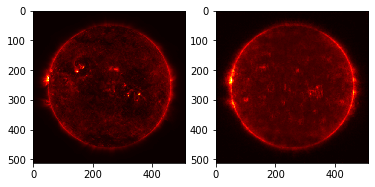


Channel: 0193 (left: original, right: predicted)


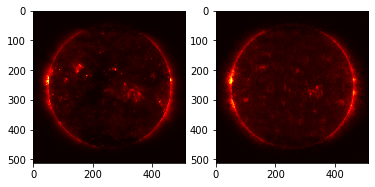


Channel: 0304 (left: original, right: predicted)


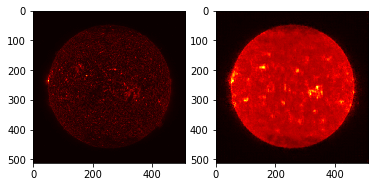

Train Epoch: 3 [210/1679 (75%)]	Loss: 0.017967
Train Epoch: 3 [220/1679 (79%)]	Loss: 0.016192
Train Epoch: 3 [230/1679 (82%)]	Loss: 0.015230
Train Epoch: 3 [240/1679 (86%)]	Loss: 0.015917
Train Epoch: 3 [250/1679 (89%)]	Loss: 0.018536
Train Epoch: 3 [260/1679 (93%)]	Loss: 0.024863
Train Epoch: 3 [270/1679 (96%)]	Loss: 0.018697
Train Epoch: 4 [0/1679 (0%)]	Loss: 0.070791

Channel: 0171 (left: original, right: predicted)


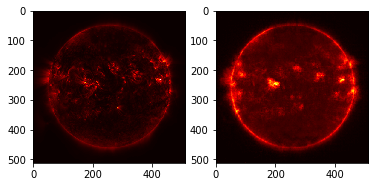


Channel: 0193 (left: original, right: predicted)


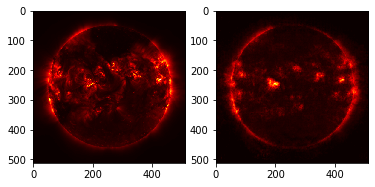


Channel: 0304 (left: original, right: predicted)


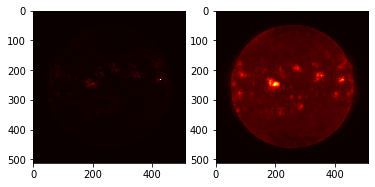

Train Epoch: 4 [10/1679 (4%)]	Loss: 0.057403
Train Epoch: 4 [20/1679 (7%)]	Loss: 0.051608
Train Epoch: 4 [30/1679 (11%)]	Loss: 0.039431
Train Epoch: 4 [40/1679 (14%)]	Loss: 0.065461
Train Epoch: 4 [50/1679 (18%)]	Loss: 0.060932
Train Epoch: 4 [60/1679 (21%)]	Loss: 0.052139
Train Epoch: 4 [70/1679 (25%)]	Loss: 0.034821
Train Epoch: 4 [80/1679 (29%)]	Loss: 0.046032
Train Epoch: 4 [90/1679 (32%)]	Loss: 0.029947
Train Epoch: 4 [100/1679 (36%)]	Loss: 0.018378

Channel: 0171 (left: original, right: predicted)


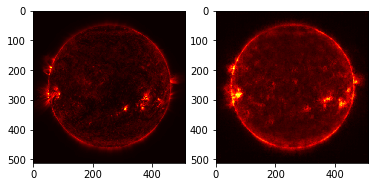


Channel: 0193 (left: original, right: predicted)


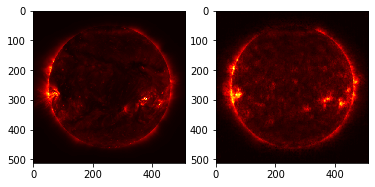


Channel: 0304 (left: original, right: predicted)


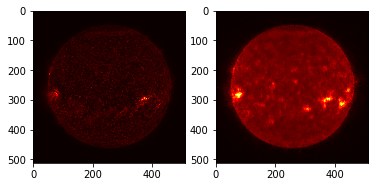

Train Epoch: 4 [110/1679 (39%)]	Loss: 0.025809
Train Epoch: 4 [120/1679 (43%)]	Loss: 0.019721
Train Epoch: 4 [130/1679 (46%)]	Loss: 0.024968
Train Epoch: 4 [140/1679 (50%)]	Loss: 0.016320
Train Epoch: 4 [150/1679 (54%)]	Loss: 0.014662
Train Epoch: 4 [160/1679 (57%)]	Loss: 0.013708
Train Epoch: 4 [170/1679 (61%)]	Loss: 0.019746
Train Epoch: 4 [180/1679 (64%)]	Loss: 0.013070
Train Epoch: 4 [190/1679 (68%)]	Loss: 0.020197
Train Epoch: 4 [200/1679 (71%)]	Loss: 0.015504

Channel: 0171 (left: original, right: predicted)


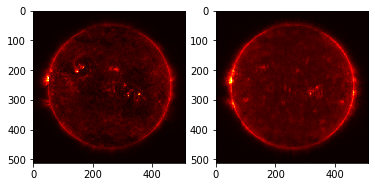


Channel: 0193 (left: original, right: predicted)


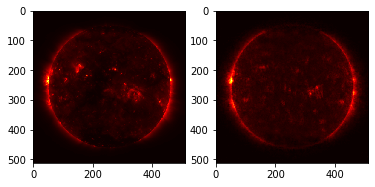


Channel: 0304 (left: original, right: predicted)


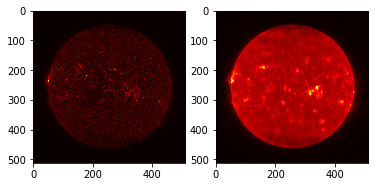

Train Epoch: 4 [210/1679 (75%)]	Loss: 0.017788
Train Epoch: 4 [220/1679 (79%)]	Loss: 0.015959
Train Epoch: 4 [230/1679 (82%)]	Loss: 0.015231


In [ ]:
# training loop
model.cuda(cuda_device)
len_data = train_data.__len__()
log_interval = 10
plot_interval = 100
# for now I am training on a single year
n_epochs = 100
train_loss = []
for epoch in range(n_epochs):
    for batch_idx, batch in enumerate(train_data_loader):
        # reshaping in order to get sequence
        # batch_size define the length of the sequence
        # print("Batch", batch.shape)
        batch = batch.to(cuda_device)
        batch = batch.unsqueeze(0)
        truth = batch[:,-1,:, :, :]
        # print("Truth size", truth.shape)
        batch_train = batch[:, :-1, :, :, :]
        # print("Batch train", batch_train.shape)
        #truth = truth.unsqueeze(1) 
        optimizer.zero_grad()
        output = model(batch_train)
        last_output = output[:, -1, :, :, :]
        loss = loss_function(last_output, truth)
        train_loss.append(float(loss))
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(batch), len(train_data_loader.dataset),
                100.0 * (batch_idx / len(train_data_loader)), float(loss)))
        if batch_idx % plot_interval == 0:
            for i, channel in enumerate(channels):
                fig = plt.figure()
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(truth.cpu().detach().numpy()[0,i,:], norm=None, cmap='hot')
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.imshow(last_output.cpu().detach().numpy()[0,i,:], norm=None, cmap='hot')
                print('\nChannel: {} (left: original, right: predicted)'.format(channel))
                plt.show()